# Emission from the relativistic charged particles

The SR (spontaneous radiation) module calculates the spectral-angular distibution of electromagnetic emission priduced by the relativistic charges using the Fourier components of Lienard-Wiechert potentials in the far field: 
$$ \cfrac{\mathrm{d}\mathcal{W}}{\mathrm{d}\Omega\, \mathrm{d}\omega} = \frac{e^2}{4\pi^2c} \sum_p \left| \int_{-\infty}^{\infty} \mathrm{d}t\,\cfrac{\bf n\!\times\! (\bf n\!-\!\beta)\!\times\!\dot{\beta}}{(1-{\bf n\,\beta})^2}\;\mathrm{e}^{i \omega (t-\mathbf{n}\mathbf{r}_e/c )}\right|^2\,, $$

This utility can be used to study the spontaneous emission from undulators or channels.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys,time
import numpy as np
from scipy.constants import c,hbar
from scipy.interpolate import griddata

from chimera.moduls.species import Specie
from chimera.moduls.chimera_main import ChimeraRun
from chimera.moduls.SR import SR
from chimera.moduls import fimera as chimera

Lets define parameters of a 50 periods undulator with a small deflection parameter $K_0=0.1$, and an electron with $\gamma_e=100$

In [2]:
K0 = 0.1 
Periods=50
g0=100.0

StepsPerPeriod=24
gg = g0/(1.+K0**2/2)**.5
vb = (1.-gg**-2)**0.5
k_res = 2*gg**2
dt = 1./StepsPerPeriod
Steps2Do = int((Periods+2)/dt)+1

Electron is added by creating a dummy specie equipped with the undulator device, and a single particle with $p_x = \sqrt{\gamma_e^2-1}$ is added

In [3]:
specie_in = {'TimeStep':dt,
             'Devices':([chimera.undul_analytic,np.array([K0, 1., 0, Periods])],)
            }

beam = Specie(specie_in)

NumParts = 1
beam.Data['coords'] = np.zeros((3,NumParts))
beam.Data['momenta'] = np.zeros((3,NumParts))

beam.Data['momenta'][0] = np.sqrt(g0**2-1)

beam.Data['coords_halfstep'] = beam.Data['coords'].copy()
beam.Data['weights'] = np.ones((NumParts,))/NumParts

chimera_in = {'Particles':(beam,),}
Chimera = ChimeraRun(chimera_in)

The SR calculator needs **Grid** attribute, deined as [($k_{min}$, $k_{max}$), ($\theta_{min}$, $\theta_{max}$), ($\phi_{min}$, $\phi_{max}$), ($N_k$, $N_\theta$, $N_\phi$)], where $k$, $\theta$ and $\phi$ are the wavenumber elevation and azimuthal angles of the emission. The **Features** attribut can contain *WavelenghtGrid*, which would provide the homogeneous grid for the wavelengths.

After the calculator is constructed, the track-container should be initiated.

In [4]:
sr_in_near = {'Grid':[(0.02*k_res,1.1*k_res),(-15,15),(-15,15),1e3,(160,160,160)],
         'TimeStep':dt,'Features':(),'Mode':'near',
        }

sr_in_far = {'Grid':[(0.02*k_res,1.1*k_res),(0,2./g0),(0.,2*np.pi),(160,80,24)],
         'TimeStep':dt,'Features':(),
        }

sr_calc_far = SR(sr_in_far)
sr_calc_near = SR(sr_in_near)
sr_calc_far.init_track(Steps2Do,beam)
sr_calc_near.init_track(Steps2Do,beam)

The simulation is run as usually, but after each (or selected) step the track point is added to the track container using **add_track** method. 

After the orbits are recorded the spectrum is calculated with **calculate_spectrum** method, which can take the component as an argument (e.g. *comp='z'*). The defalut is *comp='all'* which accounts for all components.

In [5]:
t0 = time.time()
for i in range(Steps2Do):
    Chimera.make_step(i)
    sr_calc_far.add_track(beam)
    sr_calc_near.add_track(beam)
    
print('Done orbits in {:g} sec'.format(time.time()-t0))
t0 = time.time()

sr_calc_far.calculate_spectrum()
print('Done farfield spectrum in {:g} min'.format((time.time()-t0)/60.))
t0 = time.time()

sr_calc_near.calculate_spectrum(comp='y')
print('Done nearfield spectrum in {:g} min'.format((time.time()-t0)/60. ))

Done orbits in 0.178353 sec
Done farfield spectrum in 0.166593 min
Done nearfield spectrum in 2.50729 min


The few useful functions are available:
- **get_full_spectrum** returns the full energy spectral-angular distribution, $\mathrm{d}\mathcal{W}/(\mathrm{d}\varepsilon\, \mathrm{d}\Theta)$ (dimensionless)
- **get_energy_spectrum** returns $\Theta$-integrated *get_full_spectrum*
- **get_spot** returns $\varepsilon$-integrated *get_full_spectrum*, in the units of $(dW/d\Theta)$ [J] $\cdot\lambda_0$ [$\mu$m]
- **get_spot_cartesian** is same as *get_spot* but returns the profile interpolated onto cartesian axis; takes *th_part* argument (default value is 1) to specify the cone angle relative to the full cone $(0,\theta_{max})$, and *bins=(Nx,Ny)* to specify the resolution of the cartesian grid
- **get_energy** returns full energy either in $(dW)$ [J] $\cdot\lambda_0$ [$\mu$m] 

Each of these diagnostics can take a *spect_filter* argument, which will multiply the spectral-angular distribution (shape should conform with multiplication operation). 

The marco-particles weights are either defined as in main code, *chim_units=True*, or represent number of real electrons *chim_units=False*. Since in CHIMERA the particles charge is $\propto \lambda_0$, if *chim_units=True* is used the **get_spot** and **get_energy** return Jouls.

In [6]:
FullSpect_far = sr_calc_far.get_full_spectrum(chim_units=False)
FullSpect_near = sr_calc_near.get_full_spectrum(chim_units=False)

spotXY_far,ext_far = sr_calc_far.get_spot_cartesian(chim_units=False,bins=(120,120))
spotXY_near = sr_calc_near.get_spot(chim_units=False)
ext_near = np.array(list(sum(sr_calc_near.Args['Grid'][1:3], ())))

FullEnergy_far = sr_calc_far.get_energy(chim_units=False)/k_res
FullEnergy_near = sr_calc_near.get_energy(chim_units=False)/k_res
FullEnergy_theor = sr_calc_near.J_in_um* (7*np.pi/24)/137.*K0**2*(1+K0**2/2)*Periods

print('** Full energy in far field agrees with theory with {:.1f}% precision'. \
      format(100*(2*(FullEnergy_far-FullEnergy_theor)/(FullEnergy_far+FullEnergy_theor))))
print('** Full energy in near field agrees with theory with {:.1f}% precision'. \
      format(100*(2*(FullEnergy_near-FullEnergy_near)/(FullEnergy_near+FullEnergy_theor))))
print('** Full energy in far and near fields agree with {:.1f}% precision'. \
      format(100*m(2*(FullEnergy_far-FullEnergy_near)/(FullEnergy_far+FullEnergy_near))))

** Full energy in far field agrees with theory with 4.8% precision
** Full energy in near field agrees with theory with 12.3% precision
** Full energy in far and near fields agree with 7.5% precision


Let us compare the obtained spectrum with analytical estimates, derived with Periods>1 and $K_0<<1$ approximations. Here we use expressions from [[I. A. Andriyash et al Phys. Rev. ST Accel. Beams 16, 100703 (2013)][1]], which they can be easily derived or found and any textbook on undulator radiation.
- the resonant frequence depends on the angle as $\propto \left(1+\theta^2\gamma_e^2\right)^{-1}$ 
- the energy in units of full number of photons with fundamental wavelength is 
$$N_{ph} = \frac{7\pi \alpha}{24}\, K_0^2\, \left(1+\frac{K_0^2}{2}\right)\, N_\mathrm{periods}$$
- the transverse profiles of emission are $\propto \left(1+\theta^2\gamma_e^2\right)^{-3}$ (vertical), $\propto \left(1+\theta^2\gamma_e^2\right)^{-7}$ (horizontal)

[1]:https://doi.org/10.1103/PhysRevSTAB.16.100703

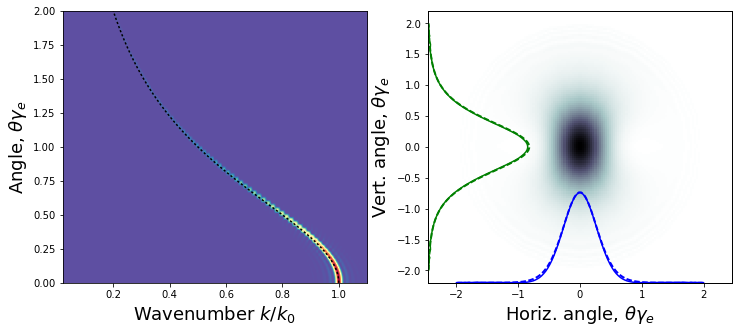

In [7]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

extent = np.array(sr_calc_far.Args["Grid"][0]+sr_calc_far.Args["Grid"][1])
extent[:2] /= k_res
extent[2:] *= g0
th,ph = sr_calc_far.Args['theta'], sr_calc_far.Args['phi']

ax1.plot( 1./(1.+(th*g0)**2), th*g0, ':', c='k',lw=1.5)
ax1.imshow(FullSpect_far.mean(-1).T,
           interpolation='spline16', aspect='auto', origin='lower',
           cmap = plt.cm.Spectral_r, extent=extent)
ax1.set_xlabel(r'Wavenumber $k/k_0$', fontsize=18)
ax1.set_ylabel(r'Angle, $\theta \gamma_e$', fontsize=18)

ax2.imshow(spotXY_far.T,origin='lower',cmap = plt.cm.bone_r,extent=g0*ext_far)
ax2.set_xlabel(r'Horiz. angle, $\theta \gamma_e$', fontsize=18)
ax2.set_ylabel(r'Vert. angle, $\theta \gamma_e$', fontsize=18)

th = np.r_[g0*ext_far[0]:g0*ext_far[1]:spotXY_far.shape[0]*1j]

ax3 = plt.twinx(ax=ax2);
ax3.plot(th, spotXY_far[:,spotXY_far.shape[0]//2+1]/spotXY_far.max(), c='b')
ax3.plot(th, (1+th**2)**-7, '--',c='b',lw=2)
ax3.set_ylim(0,3)
ax3.yaxis.set_ticks([])

ax4 = plt.twiny(ax=ax2);
ax4.plot(spotXY_far[spotXY_far.shape[0]//2+1,:]/spotXY_far.max(), th, c='g')
ax4.plot((1+th**2)**-3, th, '--',c='g',lw=2)
ax4.set_xlim(0,3)
ax4.xaxis.set_ticks([]);

To analyze radiation profile for a, for example, fundumantal wavenumber, it can be specified as *k0* argument to **get_spot**.

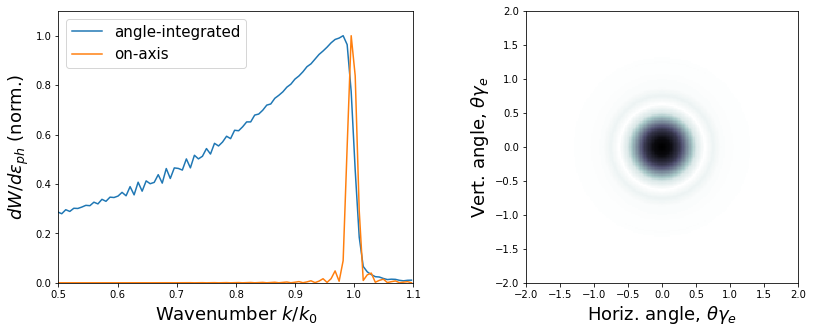

In [8]:
spotXY_k0,ext = sr_calc_far.get_spot_cartesian(chim_units=False, k0=k_res,th_part=0.2)
Spect1D = sr_calc_far.get_energy_spectrum(chim_units=False)
k_ax = sr_calc_far.get_spectral_axis()/k_res

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

ax1.plot(k_ax, Spect1D/Spect1D.max())
ax1.plot(k_ax, FullSpect_far[1:,0,0]/FullSpect_far[1:,0,0].max())
ax1.set_xlim(0.5,1.1)
ax1.set_ylim(0,1.1)
ax1.set_xlabel(r'Wavenumber $k/k_0$', fontsize=18)
ax1.set_ylabel(r'$dW/d\varepsilon_{ph}$ (norm.)', fontsize=18)
ax1.legend(('angle-integrated','on-axis'), loc=2,fontsize=15)

ax2.imshow(spotXY_k0.T,origin='lower',cmap = plt.cm.bone_r,extent=g0*ext_far)
ax2.set_xlabel(r'Horiz. angle, $\theta \gamma_e$', fontsize=18)
ax2.set_ylabel(r'Vert. angle, $\theta \gamma_e$', fontsize=18);

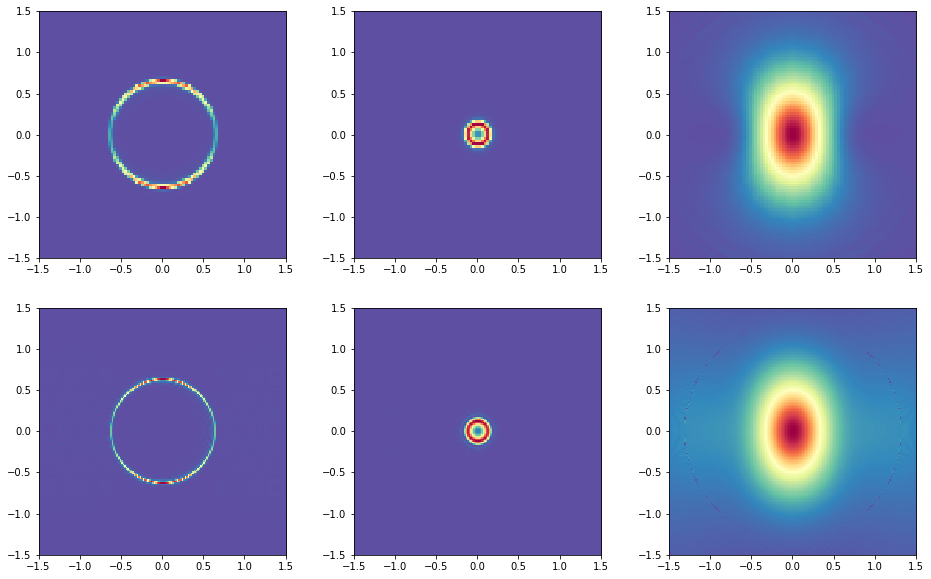

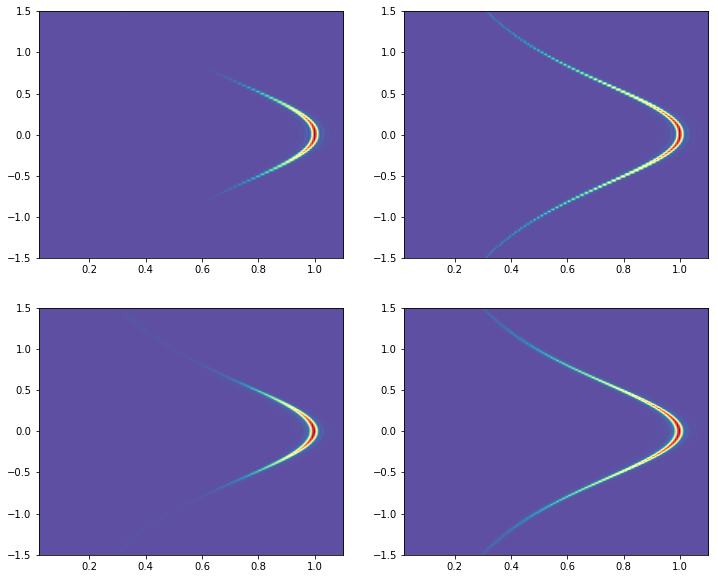

In [9]:
ext_wo_far = np.array(list(sum(sr_calc_far.Args['Grid'][0:2], ())))
ext_wo_far[:2] /= k_res
ext_wo_far[2] = -ext_wo_far[3]
ext_wo_far[2:] *= g0

ext_wo_near = np.array(list(sum(sr_calc_near.Args['Grid'][0:2], ())))
ext_wo_near[2:] *= g0/(sr_calc_near.Args['Grid'][3])
ext_wo_near[:2] /= k_res

fig,axs = plt.subplots(2,3, figsize=(16,10))
kk = 0.95*k_res
for i in range(3):
    kk = (0.7*k_res, 0.98*k_res, None)[i]
    (ax1,ax2) = axs[:,i]
    spotXY_far,ext_far = sr_calc_far.get_spot_cartesian(chim_units=False,k0=kk,bins=(120,120))
    spotXY_near = sr_calc_near.get_spot(chim_units=False,k0=kk)
    ax1.imshow(spotXY_far.T,origin='lower', cmap = plt.cm.Spectral_r,
               extent=g0*ext_far)
    ax2.imshow(spotXY_near.T, origin='lower',cmap=plt.cm.Spectral_r,
               extent=g0*ext_near/(sr_calc_near.Args['Grid'][3]) )
    for ax in (ax1,ax2):
        ax.set_xlim(-1.5,1.5)
        ax.set_ylim(-1.5,1.5)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,10))

ax1.imshow(np.hstack((FullSpect_far[:,::-1,0],FullSpect_far[:,:,12])).T,
           origin='lower',interpolation='bilinear',
           aspect='auto',cmap=plt.cm.Spectral_r,
           extent=ext_wo_far)

ax2.imshow(np.hstack((FullSpect_far[:,::-1,6],FullSpect_far[:,:,18])).T,
           origin='lower',interpolation='bilinear',
           aspect='auto',cmap=plt.cm.Spectral_r,
           extent=ext_wo_far)
        
ax3.imshow(FullSpect_near[:,:,75:86].mean(-1).T,
           origin='lower',interpolation='bilinear',
           aspect='auto',cmap=plt.cm.Spectral_r,
           extent=ext_wo_near )

ax4.imshow(FullSpect_near[:,78:86,:].mean(-2).T,
           origin='lower',interpolation='bilinear',
           aspect='auto',cmap=plt.cm.Spectral_r,
           extent=ext_wo_near )

for ax in (ax1,ax2,ax3,ax4):
    ax.set_ylim(-1.5,1.5)